# **BBM409 Assignment 4 - Animal Classification of Images using Neural Network and CNN**

# Importing libraries

In [73]:
import os  # to loop through folders and images

from math import log, e
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps  # to convert images to numpy arrays

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split  # to create train, test and validation sets

# Utility functions

In [70]:
CATEGORIES = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
ABBR_CATEGORIES = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

In [75]:
def plot_confusion_matrix(cm, category, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category))
    plt.xticks(tick_marks, category, rotation=45)
    plt.yticks(tick_marks, category)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [71]:
def build_confusion_mtx(test_labels_ids, predicted_categories, abbr_categories):

    cm = confusion_matrix(test_labels_ids, predicted_categories)
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_normalized, abbr_categories, title='Normalized confusion matrix')

    plt.show()

# Reading and adjusting of the dataset

In [2]:
os.chdir('C:\\Users\\white power\\Desktop\\ML-4\\raw-img')

X, y = list(), list()
classes_map = dict()
classes = os.listdir()
n_classes = len(classes)

# To resize images
NEW_SIZE = (128, 128)

for i, class_type in enumerate(classes):
    os.chdir('C:\\Users\\white power\\Desktop\\ML-4\\raw-img\\' + class_type)
    classes_map[i] = class_type

    for filename in os.listdir():
        # Reading the image
        img = Image.open(filename)

        # Resize, greyscale 
        # and make the data type of array elements float16 to reduce RAM usage
        X.append(np.array(ImageOps.grayscale(img.resize(NEW_SIZE))).astype('float16'))

        local_y = [0] * n_classes  # creating labels
        local_y[i] = 1
        y.append(np.array(local_y, dtype=np.uint8))

# converting to numpy arrays to work faster
X = np.array(X)
y = np.array(y)

# train - test - validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# flattening and normalizing of data, and reshaping of y
X_train = X_train.reshape(X_train.shape[0], -1).T / 255
X_test = X_test.reshape(X_test.shape[0], -1).T / 255
X_val = X_val.reshape(X_val.shape[0], -1).T / 255

y_train = y_train.T
y_test = y_test.T
y_val = y_val.T

In [3]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(16384, 15707)
(16384, 5236)
(16384, 5236)
(10, 15707)
(10, 5236)
(10, 5236)


# Activation functions and derivatives

In [4]:
def relu(Z):
    """ReLU function implementation.

        :param numpy.ndarray Z: Output of the linear layer
        :return: Post-activation parameter (same shape as Z) and Z for cache
        :rtype: (numpy.ndarray, numpy.ndarray)
        """

    return np.maximum(0, Z), Z

In [5]:
def tanh(Z):
    """Tanh function implementation.

        :param numpy.ndarray Z: Output of the linear layer
        :return: Post-activation parameter (same shape as Z) and Z for cache
        :rtype: (numpy.ndarray, numpy.ndarray)
        """

    return np.tanh(Z), Z

In [6]:
def sigmoid(Z):
    """Sigmoid function implementation.

        :param numpy.ndarray Z: Output of the linear layer
        :return: Post-activation parameter (same shape as Z) and Z for cache
        :rtype: (numpy.ndarray, numpy.ndarray)
        """

    return 1 / (1 + np.exp(-Z)), Z

In [7]:
def softmax(Z):
    """Softmax function implementation.

        :param numpy.ndarray Z: Output of the linear layer
        :return: Post-activation parameter (same shape as Z) and Z for cache
        :rtype: (numpy.ndarray, numpy.ndarray)
        """
    
    exponentiated = np.exp(Z)
    
    return exponentiated / np.sum(exponentiated, axis = 0), Z

In [8]:
def relu_backward(dA):
    """Derivative of ReLU implementation to use in backward propagation.

        :param numpy.ndarray dA: Post-activation gradient
        :return: Gradient of the cost with respect to Z
        :rtype: numpy.ndarray
        """

    return np.array(dA > 0, dtype = np.float32)

In [9]:
def tanh_backward(dA):
    """Derivative of sigmoid implementation to use in backward propagation.

        :param numpy.ndarray dA: Post-activation gradient
        :return: Gradient of the cost with respect to Z
        :rtype: numpy.ndarray
        """

    return 1 - np.power(np.tanh(dA), 2)

In [10]:
def sigmoid_backward(dA, cache):
    """Derivative of sigmoid implementation to use in backward propagation.

        :param numpy.ndarray dA: Post-activation gradient
        :param numpy.ndarray cache: 'Z' for using in backward propagation
        :return: Gradient of the cost with respect to Z
        :rtype: numpy.ndarray
        """

    s = 1 / (1 + np.exp(-cache))
    dZ = dA * s * (1 - s)

    return dZ

# Forward propagation module


In [11]:
def initialize_parameters(layer_dims):
    """Initialize weights and biases of layers randomly and with zeros, respectively

        :param list layer_dims: Dimensions of each layer
        :return: Weight matrix
                 of shape (layer_dims[l], layer_dims[l - 1]),
                 Bias vector
                 of shape (layer_dims[l], 1)
        :rtype: dict
        """

    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)  # number of layers

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))

    return parameters

In [12]:
def linear_forward(A, W, b):
    """Forward propagation's linear part.

        :param numpy.ndarray A: Activations from previous layer
                                of shape (size of previous layer, number of examples)
        :param numpy.ndarray W: Weights matrix
                                of shape (size of current layer, size of previous layer)
        :param numpy.ndarray b: Bias vector
                                of shape (size of the current layer, 1)
        :return: Pre-activation parameter and
                 a tuple containing 'A', 'W' and 'b'
        :rtype: (numpy.ndarray, (numpy.ndarray, numpy.ndarray, numpy.ndarray))
        """

    return np.dot(W, A) + b, (A, W, b)

In [13]:
def linear_activation_forward(A_prev, W, b, activation):
    """Forward propagation's linear -> activation part.

        :param numpy.ndarray A_prev: Activations from previous layer
                                     of shape (size of previous layer, number of examples)
        :param numpy.ndarray W: Weights matrix
                                of shape (size of current layer, size of previous layer)
        :param numpy.ndarray b: Bias vector
                                of shape (size of the current layer, 1)
        :param str activation: The activation to be used in this layer,
                               'softmax' or 'relu'
        :return: Post-activation value, 'linear_cache', 'activation_cache'
        :rtype: (numpy.ndarray, ((numpy.ndarray, numpy.ndarray, numpy.ndarray), 
                (numpy.ndarray, numpy.ndarray, numpy.ndarray)))
        """

    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
    elif activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)  # "linear_cache" = (A_prev, W, b)
        A, activation_cache = softmax(Z)  # "activation_cache" = "Z"

    return A, (linear_cache, activation_cache)

In [14]:
def L_model_forward(X, parameters, activation_func='relu'):
    """Forward propagation's [linear -> ReLU] * (L - 1) -> linear -> softmax part.

        :param numpy.ndarray X: data of shape (input size, number of examples)
        :param dict parameters: output of initialize_parameters()
        :return: last post-activation value and
                 every cache of linear_activation_forward() (L-1 units and indexed 0 to L-1)
        """

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers

    # Every layer's (except last) linear -> ReLU process
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation_func)
        caches.append(cache)

    # Last layer's linear -> softmax process
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    caches.append(cache)

    return AL, caches

# Cost function

In [15]:
def compute_cost(AL, y, loss_func='nnl'):
    """Negative log likelihood cost function.

        :param numpy.ndarray AL: Probability vector, output of the forward propagation
        :param numpy.ndarray y: True label vector
        :param str loss_func: Objection function to be used in computing cost
        :return: Cost of the current weight's output
        :rtype: float
        """

    m = y.shape[1]  # instance count
    cost = 0

    if loss_func == 'nll':  # negative log-likelihood loss
        for i in range(m):
            cost += -log(AL[:, i][np.argmax(y[:, i])])

        cost /= m
    elif loss_func == 'cel':  # categorical cross-entropy loss
        cost = -(1 / m) * np.sum(y * np.log(AL))

    return cost

# Backward propagation module

In [16]:
def linear_backward(dZ, cache):
    """Backward propagation's linear reversing part.

        :param numpy.ndarray dZ: Data of shape (input size, number of examples)
        :param tuple cache: (A_prev, W, b) values from the forward propagation
        :return: Gradient of the cost wrt to the activation (from previous layer), 
                 W (from current layer), and b (from current layer)
        :rtype: (numpy.ndarray, numpy.ndarray, numpy.ndarray)
        """

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    """Backward propagation's linear -> activation part.

        :param numpy.ndarray dA: Post-activation gradient for current layer l
        :param tuple cache: (linear_cache, activation_cache) values for cache
        :param str activation: Activation function to be used in this layer
        :return: Gradient of the cost wrt to the activation (from previous layer), 
                 W (from current layer), and b (from current layer)
        :rtype: (numpy.ndarray, numpy.ndarray, numpy.ndarray)
        """

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA)
    elif activation == "tanh":
        dZ = tanh_backward(dA)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = dA
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [17]:
def L_model_backward(AL, Y, caches, loss_func='nll', activation_func='relu'):
    """Backward propagation's wrapped function.

        :param numpy.ndarray AL: Probability vector, output of the forward propagation
        :param numpy.ndarray Y: True label vector
        :param list caches: Caches of layers
        :return: Gradients
        :rtype: dict
        """

    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # after this line, Y is the same shape as AL
    
    if loss_func == 'nll':
        dAL = AL - 1  # derivative of the negative log likelihood with respect to the softmax
    elif loss_func == 'cel':
        dAL = AL - Y
    
    # softmax -> linear
    current_cache = caches[L-1]  # Last Layer
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "softmax")
    
    # remaining layers
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation_func)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [18]:
def update_parameters(parameters, grads, learning_rate):
    """Update parameters using gradient descent.

        :param dict parameters: Parameters
        :param dict grads: Gradients, output of L_model_backward
        :param list caches: Caches of layers
        :return: Updated parameters
        :rtype: dict
        """

    L = len(parameters) // 2  # number of layers in the neural network

    # Updating
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

# Model

In [45]:
def L_layer_model(X, Y, layers_dims, loss_func='nll', activation_func='relu', learning_rate=0.0075, num_epochs=3000, print_cost=False):
    """L-layer neural network implementation.

        :param numpy.ndarray X: Data of shape (input size, number of examples)
        :param numpy.ndarray Y: True label vector
        :param list layers_dims: Size of the layers (input and output layer included)
        :param str loss_func: Loss function to be used in computing cost
        :param float learning_rate: Learning rate of the gradient descent update rule
        :param int num_epochs: Number of iterations
        :param int print_cost: If true, it prints the cost at every epoch
        :return: Parameters learnt by the model
        :rtype: dict
        """

    np.random.seed(1)
    costs = []
    m = Y.shape[1]
    decay_rate = 1
    updated_learning_rate = learning_rate
    
    parameters = initialize_parameters(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_epochs):
        # Mini-batch gradient descent
        for j in range(0, int(m / batch_size)):
            begin = j * batch_size
            end = begin + batch_size
            batch_x = X[:, begin:end]
            batch_y = Y[:, begin:end]
            
            #print('forward starts')
            # Forward propagation
            AL, caches = L_model_forward(batch_x, parameters, activation_func)
            #print('compute cost starts')
            # Compute cost
            cost = compute_cost(AL, batch_y, loss_func)
            #print('backward starts')
            # Backward propagation
            grads = L_model_backward(AL, batch_y, caches, loss_func, activation_func)
            #print('update starts')
            # Update parameters
            parameters = update_parameters(parameters, grads, updated_learning_rate)
            #print()
            
        updated_learning_rate = 1 / (1 + decay_rate * i) * learning_rate
        if print_cost:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [101]:
from sklearn.metrics import classification_report

def accuracy(inp, labels, parameters):
    forward_cache = L_model_forward(inp, parameters)
    a_out = forward_cache[0]   # containes propabilities with shape(10, 1)
    
    a_out = np.argmax(a_out, 0)  # 0 represents row wise 
    
    labels = np.argmax(labels, 0)
    
    print(classification_report(labels, a_out))
    
    acc = np.mean(a_out == labels)*100
    
    return acc, a_out, labels

In [46]:
learning_rate = 0.01  # 0.005 - 0.02
batch_size = 32  # 16 - 128
num_epochs = 35

# Tests

Almost for all implementations, test set's accuracy is better than training set's. It means there is a underfitting problem. 

Implementations that uses relu as activation and negative log loss as loss function have nearly %8 accuracy, which is really low. However, the implementations that uses tanh and cross-entropy instead of the first ones, they have nearly %20 accuracy. Therefore, we can say tanh and cross-entropy combine results better in this experiment.

In the first implementation, we have trained the model with n and n * 2 hidden units separately. And results didn't change significantly.

If we compare the neural networks's accuracy with VGG's accuracy, it is obvious that neural network performs way much worse than vgg-19.

## One hidden layer NN

In [47]:
layer_sizes = [X_train.shape[0], 15, len(classes)]

Cost after iteration 0: 2.302648
Cost after iteration 1: 2.302874
Cost after iteration 2: 2.302928
Cost after iteration 3: 2.302952
Cost after iteration 4: 2.302965
Cost after iteration 5: 2.302973
Cost after iteration 6: 2.302978
Cost after iteration 7: 2.302982
Cost after iteration 8: 2.302985
Cost after iteration 9: 2.302988
Cost after iteration 10: 2.302990
Cost after iteration 11: 2.302991
Cost after iteration 12: 2.302992
Cost after iteration 13: 2.302993
Cost after iteration 14: 2.302994
Cost after iteration 15: 2.302995
Cost after iteration 16: 2.302996
Cost after iteration 17: 2.302996
Cost after iteration 18: 2.302997
Cost after iteration 19: 2.302997
Cost after iteration 20: 2.302997
Cost after iteration 21: 2.302998
Cost after iteration 22: 2.302998
Cost after iteration 23: 2.302998
Cost after iteration 24: 2.302998
Cost after iteration 25: 2.302998
Cost after iteration 26: 2.302999
Cost after iteration 27: 2.302999
Cost after iteration 28: 2.302999
Cost after iteration 29:

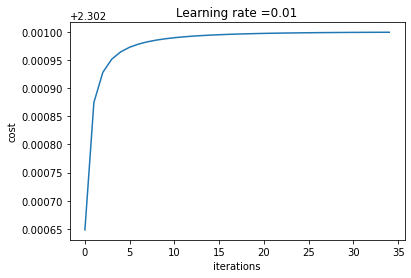

In [48]:
parameters = L_layer_model(X_train, y_train, layer_sizes, 'nll', 'relu', learning_rate, num_epochs, True)
os.chdir('C:\\Users\\white power\\Desktop\\ML-4')
np.save('parameters.npy', parameters)

In [102]:
acc1, predictions1, labels1 = accuracy(X_train, y_train, parameters)
acc2, predictions2, labels2 = accuracy(X_test, y_test, parameters)

              precision    recall  f1-score   support

           0       0.15      0.00      0.00      2881
           1       0.09      0.12      0.10      1573
           2       0.04      0.06      0.04       888
           3       0.06      0.04      0.05      1280
           4       0.09      0.15      0.11      1822
           5       0.06      0.12      0.08      1003
           6       0.05      0.07      0.06      1134
           7       0.13      0.20      0.16      1115
           8       0.31      0.00      0.00      2866
           9       0.08      0.20      0.11      1145

    accuracy                           0.08     15707
   macro avg       0.10      0.10      0.07     15707
weighted avg       0.13      0.08      0.06     15707

              precision    recall  f1-score   support

           0       0.18      0.00      0.00      1008
           1       0.11      0.14      0.12       523
           2       0.07      0.11      0.08       287
           3       0.08 

In [92]:
print(acc1)
print(acc2)

7.8181702425670085
8.403361344537815


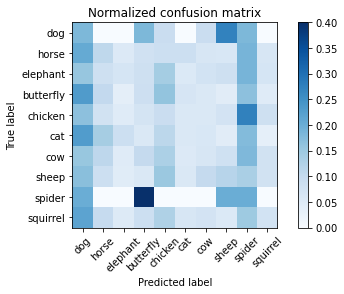

In [93]:
build_confusion_mtx(predictions2.tolist(), labels2.tolist(), ABBR_CATEGORIES)

It seems this implementation predicts test examples mostly as butterfly. And also we can see that spider and dog is the most accurately classified categories

Cost after iteration 0: 2.302840
Cost after iteration 1: 2.302886
Cost after iteration 2: 2.302893
Cost after iteration 3: 2.302896
Cost after iteration 4: 2.302897
Cost after iteration 5: 2.302897
Cost after iteration 6: 2.302898
Cost after iteration 7: 2.302898
Cost after iteration 8: 2.302898
Cost after iteration 9: 2.302898
Cost after iteration 10: 2.302898
Cost after iteration 11: 2.302898
Cost after iteration 12: 2.302898
Cost after iteration 13: 2.302898
Cost after iteration 14: 2.302898
Cost after iteration 15: 2.302898
Cost after iteration 16: 2.302898
Cost after iteration 17: 2.302898
Cost after iteration 18: 2.302898
Cost after iteration 19: 2.302898


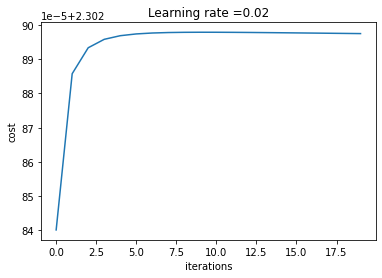

In [108]:
layer_sizes = [X_train.shape[0], 30, len(classes)]
parametersd = L_layer_model(X_train, y_train, layer_sizes, 'nll', 'relu', learning_rate, num_epochs, True)
os.chdir('C:\\Users\\white power\\Desktop\\ML-4')
np.save('parametersd.npy', parametersd)

In [110]:
acc1, predictions1, labels1 = accuracy(X_train, y_train, parameters)
acc2, predictions2, labels2 = accuracy(X_test, y_test, parameters)
print(acc1)
print(acc2)

              precision    recall  f1-score   support

           0       0.15      0.00      0.00      2881
           1       0.09      0.12      0.10      1573
           2       0.04      0.06      0.04       888
           3       0.06      0.04      0.05      1280
           4       0.09      0.15      0.11      1822
           5       0.06      0.12      0.08      1003
           6       0.05      0.07      0.06      1134
           7       0.13      0.20      0.16      1115
           8       0.31      0.00      0.00      2866
           9       0.08      0.20      0.11      1145

    accuracy                           0.08     15707
   macro avg       0.10      0.10      0.07     15707
weighted avg       0.13      0.08      0.06     15707

              precision    recall  f1-score   support

           0       0.18      0.00      0.00      1008
           1       0.11      0.14      0.12       523
           2       0.07      0.11      0.08       287
           3       0.08 

Cost after iteration 0: 2.163526
Cost after iteration 1: 2.163447
Cost after iteration 2: 2.161060
Cost after iteration 3: 2.160586
Cost after iteration 4: 2.160496
Cost after iteration 5: 2.160471
Cost after iteration 6: 2.160454
Cost after iteration 7: 2.160436
Cost after iteration 8: 2.160417
Cost after iteration 9: 2.160398
Cost after iteration 10: 2.160379
Cost after iteration 11: 2.160361
Cost after iteration 12: 2.160345
Cost after iteration 13: 2.160329
Cost after iteration 14: 2.160315
Cost after iteration 15: 2.160301
Cost after iteration 16: 2.160289
Cost after iteration 17: 2.160278
Cost after iteration 18: 2.160267
Cost after iteration 19: 2.160257
Cost after iteration 20: 2.160248
Cost after iteration 21: 2.160240
Cost after iteration 22: 2.160232
Cost after iteration 23: 2.160224
Cost after iteration 24: 2.160217
Cost after iteration 25: 2.160211
Cost after iteration 26: 2.160205
Cost after iteration 27: 2.160199
Cost after iteration 28: 2.160194
Cost after iteration 29:

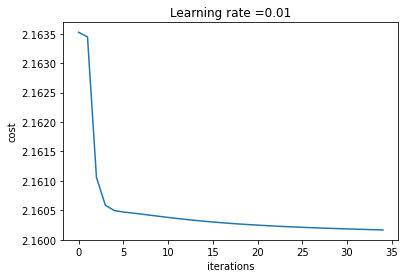

In [51]:
parameterst = L_layer_model(X_train, y_train, layer_sizes, 'cel', 'tanh', learning_rate, num_epochs, True)
os.chdir('C:\\Users\\white power\\Desktop\\ML-4')
np.save('parameterst.npy', parameterst)

In [103]:
acc1, preds1, labels1 = accuracy(X_train, y_train, parameterst)
acc2, preds2, labels2 = accuracy(X_test, y_test, parameterst)
print(acc1)
print(acc2)

C:\Users\white power\anaconda3\envs\CV_HW\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.18      1.00      0.31      2881
           1       0.00      0.00      0.00      1573
           2       0.00      0.00      0.00       888
           3       0.00      0.00      0.00      1280
           4       0.00      0.00      0.00      1822
           5       0.00      0.00      0.00      1003
           6       0.00      0.00      0.00      1134
           7       0.00      0.00      0.00      1115
           8       0.00      0.00      0.00      2866
           9       0.00      0.00      0.00      1145

    accuracy                           0.18     15707
   macro avg       0.02      0.10      0.03     15707
weighted avg       0.03      0.18      0.06     15707

              precision    recall  f1-score   support

           0       0.19      1.00      0.32      1008
           1       0.00      0.00      0.00       523
           2       0.00      0.00      0.00       287
           3       0.00 

## Two hidden layer NN

In [53]:
layer_sizes = [X_train.shape[0], 20, 15, len(classes)]

Cost after iteration 0: 2.302613
Cost after iteration 1: 2.302598
Cost after iteration 2: 2.302593
Cost after iteration 3: 2.302590
Cost after iteration 4: 2.302589
Cost after iteration 5: 2.302587
Cost after iteration 6: 2.302586
Cost after iteration 7: 2.302586
Cost after iteration 8: 2.302585
Cost after iteration 9: 2.302585
Cost after iteration 10: 2.302584
Cost after iteration 11: 2.302584
Cost after iteration 12: 2.302583
Cost after iteration 13: 2.302583
Cost after iteration 14: 2.302583
Cost after iteration 15: 2.302583
Cost after iteration 16: 2.302582
Cost after iteration 17: 2.302582
Cost after iteration 18: 2.302582
Cost after iteration 19: 2.302582
Cost after iteration 20: 2.302582
Cost after iteration 21: 2.302581
Cost after iteration 22: 2.302581
Cost after iteration 23: 2.302581
Cost after iteration 24: 2.302581
Cost after iteration 25: 2.302581
Cost after iteration 26: 2.302581
Cost after iteration 27: 2.302581
Cost after iteration 28: 2.302581
Cost after iteration 29:

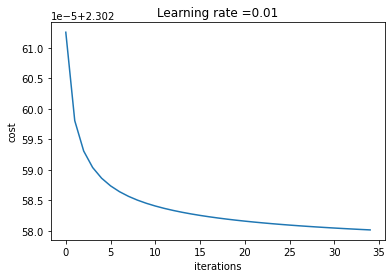

In [54]:
parameters2 = L_layer_model(X_train, y_train, layer_sizes, 'nll', 'relu', learning_rate, num_epochs, True)
os.chdir('C:\\Users\\white power\\Desktop\\ML-4')
np.save('parameters2.npy', parameters2)

In [104]:
acc1, preds1, labels1 = accuracy(X_train, y_train, parameters2)
acc2, preds2, labels2 = accuracy(X_test, y_test, parameters2)
print(acc1)
print(acc2)

              precision    recall  f1-score   support

           0       0.17      0.07      0.10      2881
           1       0.08      0.06      0.07      1573
           2       0.06      0.18      0.09       888
           3       0.07      0.08      0.07      1280
           4       0.12      0.13      0.13      1822
           5       0.06      0.06      0.06      1003
           6       0.11      0.07      0.09      1134
           7       0.16      0.08      0.10      1115
           8       0.24      0.33      0.28      2866
           9       0.07      0.07      0.07      1145

    accuracy                           0.13     15707
   macro avg       0.11      0.11      0.11     15707
weighted avg       0.14      0.13      0.12     15707

              precision    recall  f1-score   support

           0       0.21      0.07      0.11      1008
           1       0.08      0.06      0.07       523
           2       0.05      0.17      0.08       287
           3       0.06 

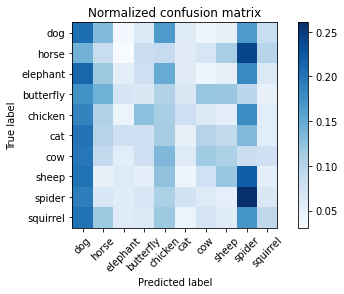

In [83]:
build_confusion_mtx(preds2, labels2, ABBR_CATEGORIES)

It seems this implementation predicts test examples mostly as spider and dog. And also we can see that spider is the most accurately classified category

Cost after iteration 0: 2.163537
Cost after iteration 1: 2.163447
Cost after iteration 2: 2.161060
Cost after iteration 3: 2.160586
Cost after iteration 4: 2.160496
Cost after iteration 5: 2.160471
Cost after iteration 6: 2.160454
Cost after iteration 7: 2.160436
Cost after iteration 8: 2.160417
Cost after iteration 9: 2.160398
Cost after iteration 10: 2.160379
Cost after iteration 11: 2.160361
Cost after iteration 12: 2.160345
Cost after iteration 13: 2.160329
Cost after iteration 14: 2.160315
Cost after iteration 15: 2.160301
Cost after iteration 16: 2.160289
Cost after iteration 17: 2.160278
Cost after iteration 18: 2.160267
Cost after iteration 19: 2.160257
Cost after iteration 20: 2.160248
Cost after iteration 21: 2.160240
Cost after iteration 22: 2.160232
Cost after iteration 23: 2.160224
Cost after iteration 24: 2.160217
Cost after iteration 25: 2.160211
Cost after iteration 26: 2.160205
Cost after iteration 27: 2.160199
Cost after iteration 28: 2.160194
Cost after iteration 29:

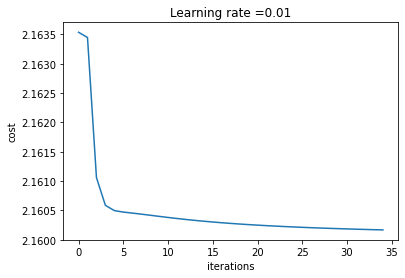

In [56]:
parameters2t = L_layer_model(X_train, y_train, layer_sizes, 'cel', 'tanh', learning_rate, num_epochs, True)
os.chdir('C:\\Users\\white power\\Desktop\\ML-4')
np.save('parameters2t.npy', parameters2t)

In [105]:
acc1, preds1, labels1 = accuracy(X_train, y_train, parameters2t)
acc2, preds2, labels2 = accuracy(X_test, y_test, parameters2t)
print(acc1)
print(acc2)

C:\Users\white power\anaconda3\envs\CV_HW\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2881
           1       0.00      0.00      0.00      1573
           2       0.00      0.00      0.00       888
           3       0.00      0.00      0.00      1280
           4       0.00      0.00      0.00      1822
           5       0.00      0.00      0.00      1003
           6       0.00      0.00      0.00      1134
           7       0.00      0.00      0.00      1115
           8       0.18      1.00      0.31      2866
           9       0.00      0.00      0.00      1145

    accuracy                           0.18     15707
   macro avg       0.02      0.10      0.03     15707
weighted avg       0.03      0.18      0.06     15707

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1008
           1       0.00      0.00      0.00       523
           2       0.00      0.00      0.00       287
           3       0.00 

## Four hidden layer NN

In [58]:
layer_sizes = [X_train.shape[0], 30, 25, 20, 15, len(classes)]
num_epochs = 20
batch_size = 128
learning_rate = 0.02

Cost after iteration 0: 2.302585
Cost after iteration 1: 2.302585
Cost after iteration 2: 2.302585
Cost after iteration 3: 2.302585
Cost after iteration 4: 2.302585
Cost after iteration 5: 2.302585
Cost after iteration 6: 2.302585
Cost after iteration 7: 2.302585
Cost after iteration 8: 2.302585
Cost after iteration 9: 2.302585
Cost after iteration 10: 2.302585
Cost after iteration 11: 2.302585
Cost after iteration 12: 2.302585
Cost after iteration 13: 2.302585
Cost after iteration 14: 2.302585
Cost after iteration 15: 2.302585
Cost after iteration 16: 2.302585
Cost after iteration 17: 2.302585
Cost after iteration 18: 2.302585
Cost after iteration 19: 2.302585


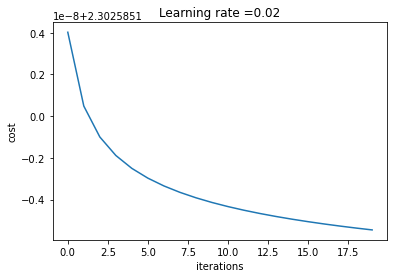

In [59]:
parameters3 = L_layer_model(X_train, y_train, layer_sizes, 'nll', 'relu', learning_rate, num_epochs, True)
os.chdir('C:\\Users\\white power\\Desktop\\ML-4')
np.save('parameters3.npy', parameters3)

In [106]:
acc1, preds1, labels1 = accuracy(X_train, y_train, parameters3)
acc2, preds2, labels2= accuracy(X_test, y_test, parameters3)
print(acc1)
print(acc2)

              precision    recall  f1-score   support

           0       0.22      0.01      0.01      2881
           1       0.00      0.00      0.00      1573
           2       0.06      0.60      0.11       888
           3       0.00      0.00      0.00      1280
           4       0.12      0.04      0.05      1822
           5       0.07      0.17      0.10      1003
           6       0.09      0.22      0.12      1134
           7       0.11      0.01      0.01      1115
           8       0.11      0.01      0.01      2866
           9       0.07      0.03      0.04      1145

    accuracy                           0.07     15707
   macro avg       0.08      0.11      0.05     15707
weighted avg       0.10      0.07      0.04     15707

              precision    recall  f1-score   support

           0       0.50      0.01      0.02      1008
           1       0.00      0.00      0.00       523
           2       0.06      0.58      0.10       287
           3       0.18 

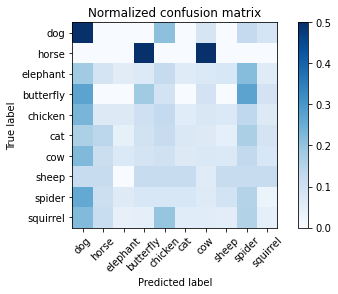

In [87]:
build_confusion_mtx(preds2, labels2, ABBR_CATEGORIES)

It seems this implementation predicts test examples mostly as butterfly and cow. And also we can see that dog is the most accurately classified category

Cost after iteration 0: 2.226656
Cost after iteration 1: 2.226131
Cost after iteration 2: 2.226124
Cost after iteration 3: 2.226111
Cost after iteration 4: 2.226094
Cost after iteration 5: 2.226078
Cost after iteration 6: 2.226065
Cost after iteration 7: 2.226053
Cost after iteration 8: 2.226044
Cost after iteration 9: 2.226036
Cost after iteration 10: 2.226029
Cost after iteration 11: 2.226023
Cost after iteration 12: 2.226018
Cost after iteration 13: 2.226014
Cost after iteration 14: 2.226010
Cost after iteration 15: 2.226006
Cost after iteration 16: 2.226003
Cost after iteration 17: 2.226000
Cost after iteration 18: 2.225998
Cost after iteration 19: 2.225995


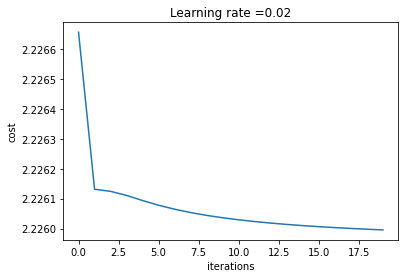

In [61]:
parameters3t = L_layer_model(X_train, y_train, layer_sizes, 'cel', 'tanh', learning_rate, num_epochs, True)
os.chdir('C:\\Users\\white power\\Desktop\\ML-4')
np.save('parameters3t.npy', parameters3t)

In [107]:
acc1, preds1, labels1 = accuracy(X_train, y_train, parameters3t)
acc2, preds2, labels2 = accuracy(X_test, y_test, parameters3t)
print(acc1)
print(acc2)

C:\Users\white power\anaconda3\envs\CV_HW\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.18      1.00      0.31      2881
           1       0.00      0.00      0.00      1573
           2       0.00      0.00      0.00       888
           3       0.00      0.00      0.00      1280
           4       0.00      0.00      0.00      1822
           5       0.00      0.00      0.00      1003
           6       0.00      0.00      0.00      1134
           7       0.00      0.00      0.00      1115
           8       0.00      0.00      0.00      2866
           9       0.00      0.00      0.00      1145

    accuracy                           0.18     15707
   macro avg       0.02      0.10      0.03     15707
weighted avg       0.03      0.18      0.06     15707

              precision    recall  f1-score   support

           0       0.19      1.00      0.32      1008
           1       0.00      0.00      0.00       523
           2       0.00      0.00      0.00       287
           3       0.00 

#**part2**

1- Fine-tuning and explanations

Fine-tuning is the way of taking weights of a pre-trained neural network and use it to 
initialize a new model being trained on data.

This is used since it speeds up the training part of the model and it is helpful with small 
datasets. Since convolutional networks has larger parameters, with smaller dataset, this causes 
overfitting. If the dataset is not too different from the dataset that was used to train the model, the 
results would suffice

-----------------------------------------------------------------------------------------------------------------


For part 2.1:
We do not touch anything with the model to set every layer to learn weights and biases in set_parameter_requires_grad2 function, which sets the layers' childs as not frozen.

In the initialize_model function we have set the fc2 which is the last fc layer as in_ftrs set by the model and out features as our classes.

Dataloaders and the dataset it transformed for the size the pre-trained model wants, which is 224 for
input size of vgg19. And the model is initialized.

Model's layers can be seen where we call the initialize_model function, and we can see which layers were set to train in the cell where "# print status" is written. For this part it is set as true for every layer to train.

Finally, the models unfrozen layers parameters has to be updated and the optimizer must be set as optimizer_ft in the following code cells, also outputs the "params to learn". 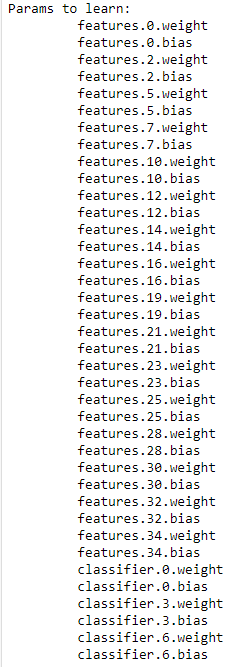

After this part, the loss function is set and training, evaluation is done for given epoch size.

With training, the validation accuracy has increased and decreased epoch to epoch with 35 epochs that we trained for, still from the plot we can see that there was still an increase, which means that we could have kept on training for more epochs.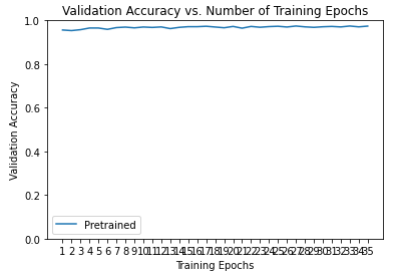

And the test result of it was : 
Accuracy of the model on the test images: 96.717 %
with total training time of:
Training complete in 240m 50s
These results are done in the two cells before build_confusion_mtx function cell.

Confusion matrix is in the cell that calls function " build_confusion_mtx", which is the last cell.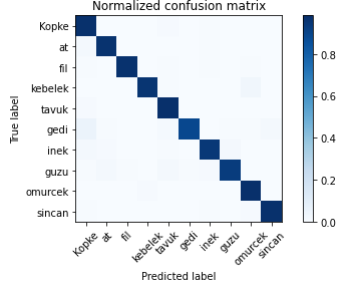

For part 2.2:
We freeze the rest of the layers and only keep the last two Fully Connected layer since the output 
channel must be same value as our used dataset class’s size, and the previous one since it was in the assignment.

To freeze only the FC layer, first, the layers parameters requires_grad is set to false for every
layer in set_parameter_requires_grad function other than last two fully connected layers.

In the initialize_model function we have set the fc1, second fc layer, as in_features from model(4096), out_features as 512, and fc2 as 512 in and out as our classes.

Dataloaders and the dataset it transformed for the size the pre-trained model wants, which is 224 for
input size of vgg19. And the model is initialized.

Model's layers can be seen where we call the initialize_model function, and we can see which layers were set to train in the cell where "# print status" is written. For this part it is set to true in the last 2 fully connected layers and the rest are set as they were.

Finally, the models unfrozen layers parameters has to be updated and the optimizer must be set as optimizer_ft in the following code cells, also outputs the "params to learn".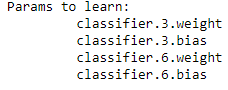

After this part, the loss function is set and training, evaluation is done for given epoch size.

With training, the validation accuracy has increased with 35 epochs that we trained for, which means that we could have kept on training for more epochs.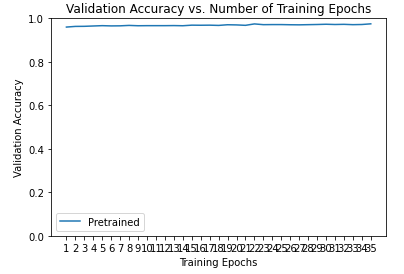

And the test result of it was : 
Accuracy of the model on the test images: 97.061 %
with total training time of:
Training complete in 88m 30s
These results are done in the two cells before build_confusion_mtx function cell.

build_confusion_mtx is in the cell that is before we initialize_model the next model, model_ft2.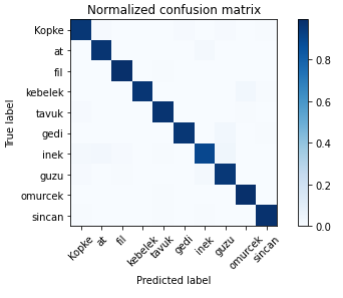

Confusion Matrix analysis for part2:

The part2.2 model, which we basically used for transfer learning did slightly better than the part2.1 model.
As far as we can see from these results, some classes such as "gedi" for part2.2 model is more accurate, but in part2.1 model classes such as "kopke" and "tavuk" showed better results.
 
Maybe, we could have changed some layers in the part2.1 model to make the accuracy better or could have increased the training time to find best place to stop for better results.

Still Vgg model is quite slow to make these try and fail methods useful, so we are happy with our results. It's accuracy negates the slowness, but these are the results we have got.

For part 2 all of these recall, precision and f1 score are quite high which means that the model works quite accurate which supports the results of accuracy we had.

recall  0.960
precision  0.969
f1_score  0.965

In [39]:
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

from glob import glob

import os

import torch

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms

import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
model_name = "vgg"

In [3]:
def get_image_paths(data_path, categories, num_train_per_cat):
    num_categories = len(categories)

    train_image_paths = []
    test_image_paths = []
    validation_image_paths = []
    
    train_labels = []
    test_labels = []
    validation_labels = []

    for category in categories:
        
        image_paths = glob(os.path.join(data_path, 'train', category, '*.jpg'))
        train_len = len(image_paths)
        #print(train_len)
        for i in range(train_len):
            train_image_paths.append(image_paths[i])
            train_labels.append(category)

        image_paths = glob(os.path.join(data_path, 'test', category, '*.jpg'))
        test_len = len(image_paths)
        #print(test_len)
        for i in range(test_len):
            test_image_paths.append(image_paths[i])
            test_labels.append(category)
            
        image_paths = glob(os.path.join(data_path, 'validation', category, '*.jpg'))
        validation_len = len(image_paths)
        #print(validation_len)
        for i in range(validation_len):
            validation_image_paths.append(image_paths[i])
            validation_labels.append(category)
        
    return train_image_paths, test_image_paths, validation_image_paths, train_labels, test_labels, validation_labels


In [4]:
DATA_PATH = 'C:\\Users\\white power\\Desktop\\ML-4\\Dataset\\'

In [5]:
train_dir = 'C:\\Users\\white power\\Desktop\\ML-4\\Dataset\\train'
test_dir = 'C:\\Users\\white power\\Desktop\\ML-4\\Dataset\\test'
validation_dir = 'C:\\Users\\white power\\Desktop\\ML-4\\Dataset\\validation'

In [7]:
CATE2ID = {v: k for k, v in enumerate(CATEGORIES)}

In [8]:
train_dataset = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))
validation_dataset = ImageFolder(validation_dir,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

In [9]:
img, label = train_dataset[0]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


In [10]:
print("Following classes are there : \n",train_dataset.classes)

Following classes are there : 
 ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Label : cane


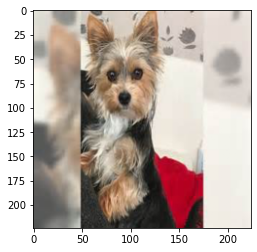

In [11]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[0])


In [12]:
from torch.utils.data.dataloader import DataLoader

batch_size = 16

print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(validation_dataset)}")

#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(validation_dataset, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)


Length of Train Data : 20938
Length of Validation Data : 2621


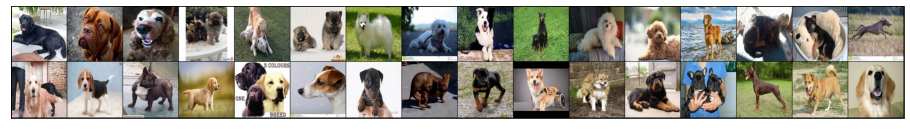

In [13]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(val_dl)

In [14]:
# For updating learning rate
def update_lrn(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, bruh=0):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    if(bruh == 0):
        torch.save(model.state_dict(), os.path.join("C:\\Users\\white power\\Desktop\\ML-4","filename1.pth"))
    if(bruh == 1):
        torch.save(model.state_dict(), os.path.join("C:\\Users\\white power\\Desktop\\ML-4","filename2.pth"))
    return model, val_acc_history


In [19]:
def set_parameter_requires_grad(model, feature_extracting):
    child_counter = 0
    fc_counter = 0
    first_counter = 0
    secondcount = 0
    for child in model.children():
        if child_counter < 1:
            print("child ",child_counter," was frozen")
            for param in child.parameters():
                #print(first_counter)
                first_counter += 1
                param.requires_grad = False
        elif child_counter == 1:
            param.requires_grad = False
            print("child ",child_counter," was frozen")
        elif child_counter == 2:
            #print("child ",child_counter)
            for param in child.parameters():
                print(fc_counter)
                if fc_counter == 0:
                    print("fc ", 0, "was frozen")
                    param.requires_grad = False
                elif fc_counter == 1:
                    print("fc ", 0, "was frozen")
                    param.requires_grad = False
                else:
                    print("not frozen ", fc_counter)
                fc_counter +=1
        else:
            print("child ",child_counter," was not frozen")
        child_counter += 1

In [20]:
def set_parameter_requires_grad2(model, feature_extracting):
    child_counter = 0
    fc_counter = 0
    first_counter = 0
    secondcount = 0
    for child in model.children():
        if child_counter < 1:
            print("child ",child_counter," was not frozen")
            for param in child.parameters():
                #print(first_counter)
                first_counter += 1
        elif child_counter == 1:
            print("child ",child_counter," was not frozen")
        elif child_counter == 2:
            #print("child ",child_counter)
            for param in child.parameters():
                print(fc_counter)
                if fc_counter == 0:
                    print("fc ", 0, "was not frozen")
                elif fc_counter == 1:
                    print("fc ", 0, "was not frozen")
                else:
                    print("not frozen ", fc_counter)
                fc_counter +=1
        else:
            print("child ",child_counter," was not frozen")
        child_counter += 1

In [21]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "vgg":
        """ VGG-19
        """
        model_ft = models.vgg19(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs2 = model_ft.classifier[3].in_features
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[3] = nn.Linear(4096, 512)
                                 
        model_ft.classifier[6] = nn.Linear(512, num_classes)            
                                 
        input_size = 224
    elif model_name == "vgg2":
        """ VGG-19
        """
        model_ft = models.vgg19(pretrained=use_pretrained)
        set_parameter_requires_grad2(model_ft, feature_extract)
        num_ftrs2 = model_ft.classifier[3].in_features
        num_ftrs = model_ft.classifier[6].in_features     
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [22]:
#modelres = torchvision.models.resnet18(pretrained=True)
#print(modelres)

In [23]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

model_ft, input_size = initialize_model("vgg", 10, feature_extract=True, use_pretrained=True)

print(model_ft)

set_parameter_requires_grad(model_ft, True)

child  0  was frozen
child  1  was frozen
0
fc  0 was frozen
1
fc  0 was frozen
2
not frozen  2
3
not frozen  3
4
not frozen  4
5
not frozen  5
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, ke

In [24]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x]) for x in ['train', 'validation']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'validation']}


Initializing Datasets and Dataloaders...


In [25]:
# print status
for name, param in model_ft.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.16.weight False
features.16.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.23.weight False
features.23.bias False
features.25.weight False
features.25.bias False
features.28.weight False
features.28.bias False
features.30.weight False
features.30.bias False
features.32.weight False
features.32.bias False
features.34.weight False
features.34.bias False
classifier.0.weight False
classifier.0.bias False
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [26]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [27]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=35, is_inception=(model_name=="inception"),bruh = 0)


Epoch 0/34
----------
train Loss: 0.4597 Acc: 0.8548
validation Loss: 0.1314 Acc: 0.9599

Epoch 1/34
----------
train Loss: 0.3211 Acc: 0.8922
validation Loss: 0.1219 Acc: 0.9630

Epoch 2/34
----------
train Loss: 0.3103 Acc: 0.8990
validation Loss: 0.1190 Acc: 0.9634

Epoch 3/34
----------
train Loss: 0.3001 Acc: 0.8974
validation Loss: 0.1161 Acc: 0.9649

Epoch 4/34
----------
train Loss: 0.2978 Acc: 0.9014
validation Loss: 0.1102 Acc: 0.9664

Epoch 5/34
----------
train Loss: 0.2816 Acc: 0.9047
validation Loss: 0.1108 Acc: 0.9653

Epoch 6/34
----------
train Loss: 0.2764 Acc: 0.9071
validation Loss: 0.1061 Acc: 0.9657

Epoch 7/34
----------
train Loss: 0.2710 Acc: 0.9090
validation Loss: 0.1117 Acc: 0.9676

Epoch 8/34
----------
train Loss: 0.2740 Acc: 0.9080
validation Loss: 0.1073 Acc: 0.9660

Epoch 9/34
----------
train Loss: 0.2683 Acc: 0.9095
validation Loss: 0.1030 Acc: 0.9664

Epoch 10/34
----------
train Loss: 0.2557 Acc: 0.9149
validation Loss: 0.1022 Acc: 0.9664

Epoch 11/

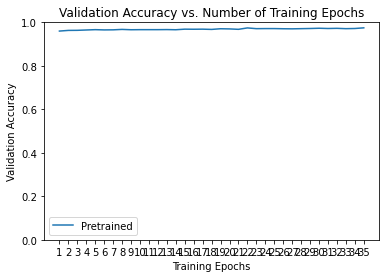

In [28]:
ohist = []
num_epochs = 35
ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [29]:
#Test the model
model_ft.eval()
accuracy = []
test_predicts = []
test_labelss = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images, labels = images.cuda(), labels.cuda()
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy.append(correct / total)
        for x in predicted:
            test_predicts.append(x.item())
        for y in labels:
            test_labelss.append(y.item())
        
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Accuracy of the model on the test images: 97.06106870229007 %


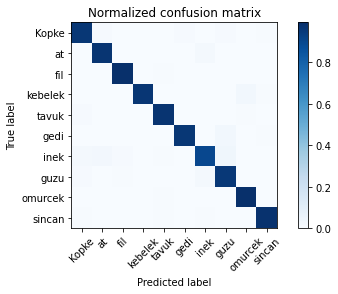

In [30]:
build_confusion_mtx(test_labelss, test_predicts, ABBR_CATEGORIES)

In [48]:
cm = confusion_matrix(test_labelss, test_predicts)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

recall = np.mean(recall)
precision = np.mean(precision)

f1_score2 = 2 / (1/precision + 1/recall)

print("recall ",recall)
print("precision ",precision)
print("f1_score2 ",f1_score2)

recall  0.9607386474193932
precision  0.969809478559107
f1_score2  0.9652527529849931


In [31]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

model_ft2, input_size = initialize_model("vgg2", 10, feature_extract, use_pretrained=True)

print(model_ft2)

set_parameter_requires_grad2(model_ft2, False)

child  0  was not frozen
child  1  was not frozen
0
fc  0 was not frozen
1
fc  0 was not frozen
2
not frozen  2
3
not frozen  3
4
not frozen  4
5
not frozen  5
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Con

In [32]:
# print status
for name, param in model_ft2.named_parameters():
    print(name, param.requires_grad)

features.0.weight True
features.0.bias True
features.2.weight True
features.2.bias True
features.5.weight True
features.5.bias True
features.7.weight True
features.7.bias True
features.10.weight True
features.10.bias True
features.12.weight True
features.12.bias True
features.14.weight True
features.14.bias True
features.16.weight True
features.16.bias True
features.19.weight True
features.19.bias True
features.21.weight True
features.21.bias True
features.23.weight True
features.23.bias True
features.25.weight True
features.25.bias True
features.28.weight True
features.28.bias True
features.30.weight True
features.30.bias True
features.32.weight True
features.32.bias True
features.34.weight True
features.34.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [33]:
model_ft2 = model_ft2.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.16.weight
	 features.16.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.32.weight
	 features.32.bias
	 features.34.weight
	 features.34.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [34]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft2, hist2 = train_model(model_ft2, dataloaders_dict, criterion, optimizer_ft, num_epochs=35, is_inception=(model_name=="inception"),bruh = 1)


Epoch 0/34
----------
train Loss: 0.4659 Acc: 0.8465
validation Loss: 0.1452 Acc: 0.9561

Epoch 1/34
----------
train Loss: 0.3385 Acc: 0.8872
validation Loss: 0.1408 Acc: 0.9535

Epoch 2/34
----------
train Loss: 0.3136 Acc: 0.8960
validation Loss: 0.1363 Acc: 0.9576

Epoch 3/34
----------
train Loss: 0.2884 Acc: 0.9041
validation Loss: 0.1115 Acc: 0.9653

Epoch 4/34
----------
train Loss: 0.2603 Acc: 0.9124
validation Loss: 0.1191 Acc: 0.9653

Epoch 5/34
----------
train Loss: 0.2503 Acc: 0.9169
validation Loss: 0.1288 Acc: 0.9592

Epoch 6/34
----------
train Loss: 0.2356 Acc: 0.9224
validation Loss: 0.1056 Acc: 0.9672

Epoch 7/34
----------
train Loss: 0.2312 Acc: 0.9225
validation Loss: 0.1043 Acc: 0.9695

Epoch 8/34
----------
train Loss: 0.2222 Acc: 0.9250
validation Loss: 0.1166 Acc: 0.9660

Epoch 9/34
----------
train Loss: 0.2142 Acc: 0.9288
validation Loss: 0.1084 Acc: 0.9699

Epoch 10/34
----------
train Loss: 0.2058 Acc: 0.9336
validation Loss: 0.1234 Acc: 0.9680

Epoch 11/

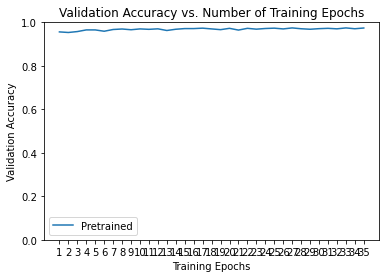

In [35]:
ohist = []
num_epochs = 35
ohist = [h.cpu().numpy() for h in hist2]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [36]:
#Test the model
model_ft2.eval()
accuracy = []
test_predicts = []
test_labelss = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images, labels = images.cuda(), labels.cuda()
        outputs = model_ft2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy.append(correct / total)
        for x in predicted:
            test_predicts.append(x.item())
        for y in labels:
            test_labelss.append(y.item())
        
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Accuracy of the model on the test images: 96.7175572519084 %


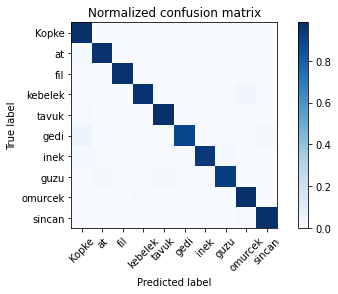

In [37]:
build_confusion_mtx(test_labelss, test_predicts, ABBR_CATEGORIES)

In [47]:
cm = confusion_matrix(test_labelss, test_predicts)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

recall = np.mean(recall)
precision = np.mean(precision)

f1_score2 = 2 / (1/precision + 1/recall)

print("recall ",recall)
print("precision ",precision)
print("f1_score2 ",f1_score2)

recall  0.9607386474193932
precision  0.969809478559107
f1_score2  0.9652527529849931


In [51]:
#parameters, gradParameters = model_ft2:getParameters()

#lightModel = model_ft2:clone('weight','bias','running_mean','running_std')

#torch.save('model1.t7',lightModel)

SyntaxError: invalid syntax (<ipython-input-51-56cb4d8a1f62>, line 1)